## Nemotron Page Element v3 Demo

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Inference
- We provide the minimal steps to run the model.

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from nemotron_table_structure_v1.model import define_model
from nemotron_table_structure_v1.utils import plot_sample, postprocess_preds_table_structure, reformat_for_plotting

In [8]:
# Load image
path = "./example.png"
img = Image.open(path).convert("RGB")
img = np.array(img)

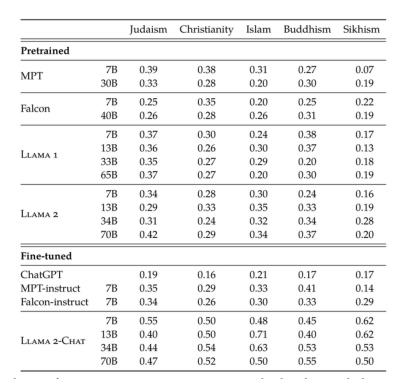

In [9]:
plt.imshow(img)
plt.axis(False)
plt.show()

In [10]:
# Load model
model = define_model("table_structure_v1")

 -> Loading weights from weights.pth


In [11]:
# Inference
with torch.inference_mode():
    x = model.preprocess(img)
    preds = model(x, img.shape)[0]

In [12]:
# Post-processing
boxes, labels, scores = postprocess_preds_table_structure(preds, model.threshold, model.labels)

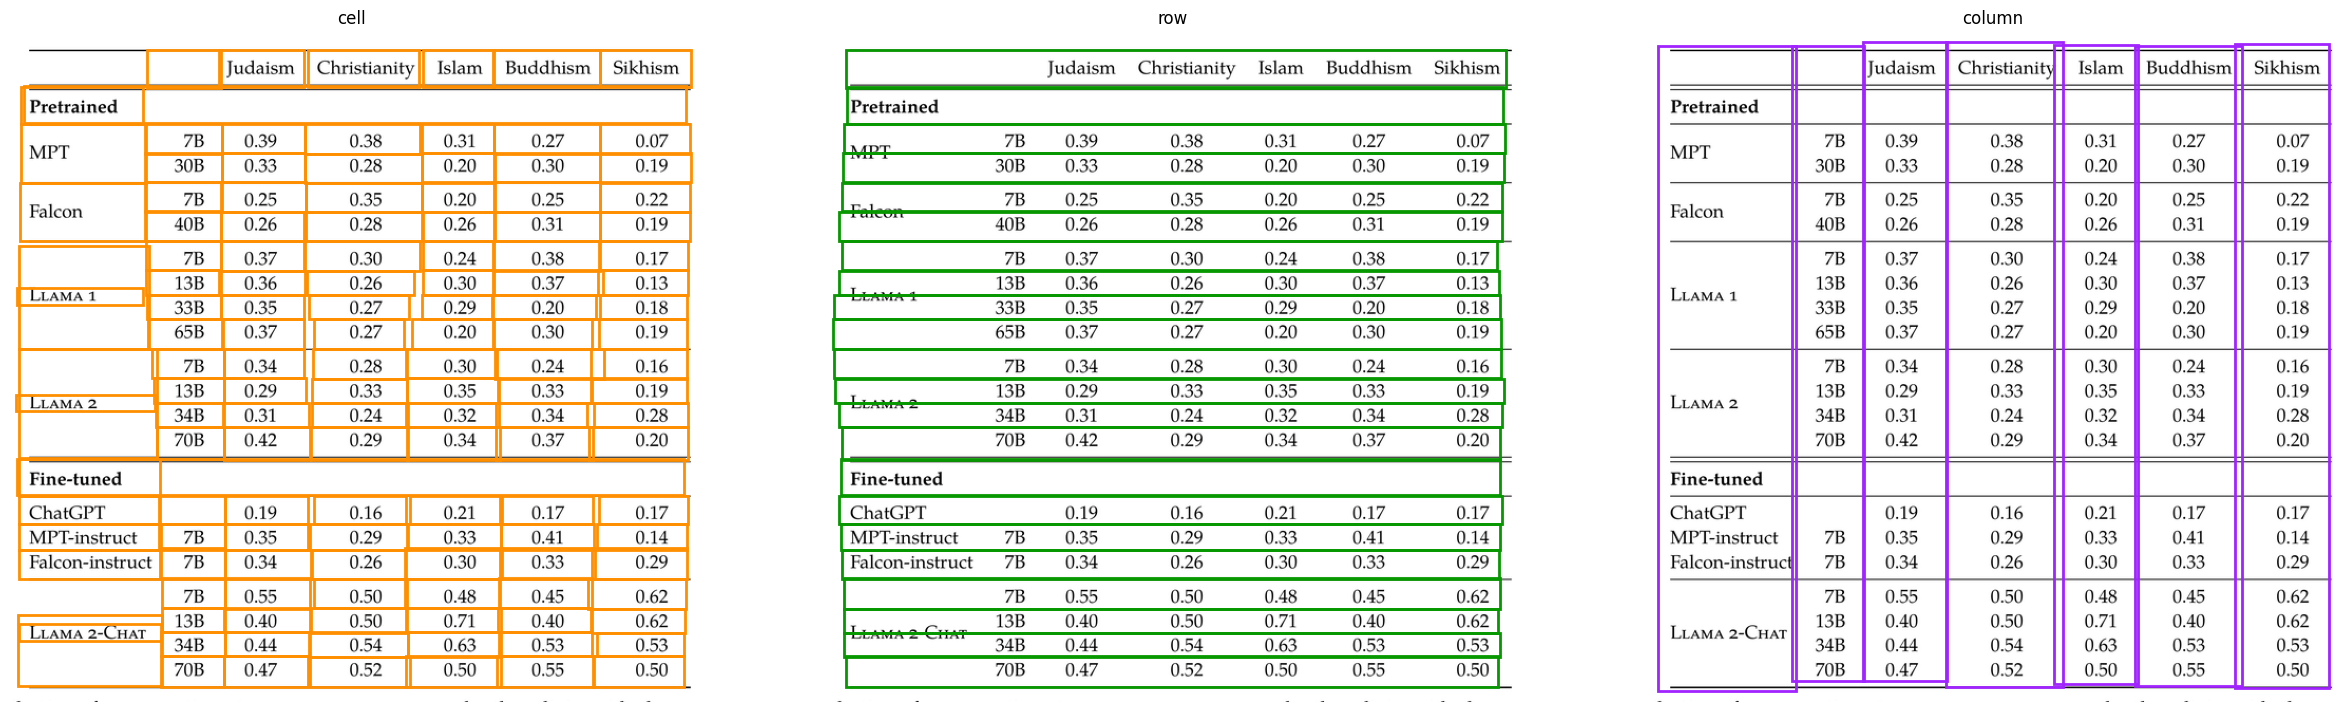

In [13]:
# Plot
boxes_plot, confs = reformat_for_plotting(boxes, labels, scores, img.shape, model.num_classes)

plt.figure(figsize=(30, 15))
for i in range(1, 4):
    boxes_plot_c = [b if j == i else [] for j, b in enumerate(boxes_plot)]
    confs_c = [c if j == i else [] for j, c in enumerate(confs)]

    plt.subplot(1, 3, i)
    plt.title(model.labels[i])
    plot_sample(img, boxes_plot_c, confs_c, labels=model.labels, show_text=False)
plt.show()

## Advanced Post-processing
- Predictions are a bit noisy as-is, we provide more utility functions for better ingestion
- Depending on your use-case, you might chose to apply some of the steps

In [14]:
from nemotron_table_structure_v1.post_processing.wbf import weighted_boxes_fusion
from nemotron_table_structure_v1.utils import reorder_boxes

### Remove overlapping boxes using WBF
- Applied twice because once is not enough in some rare cases
- This fixes some edge cases with multicells

In [15]:
for _ in range(2):
    boxes, labels, scores = weighted_boxes_fusion(
        boxes[:, None],
        labels[:, None],
        scores[:, None],
        merge_type="biggest",
        conf_type="max",
        iou_thr=0.1,
    )

boxes, labels, scores = reorder_boxes(boxes, labels, model.labels, scores)

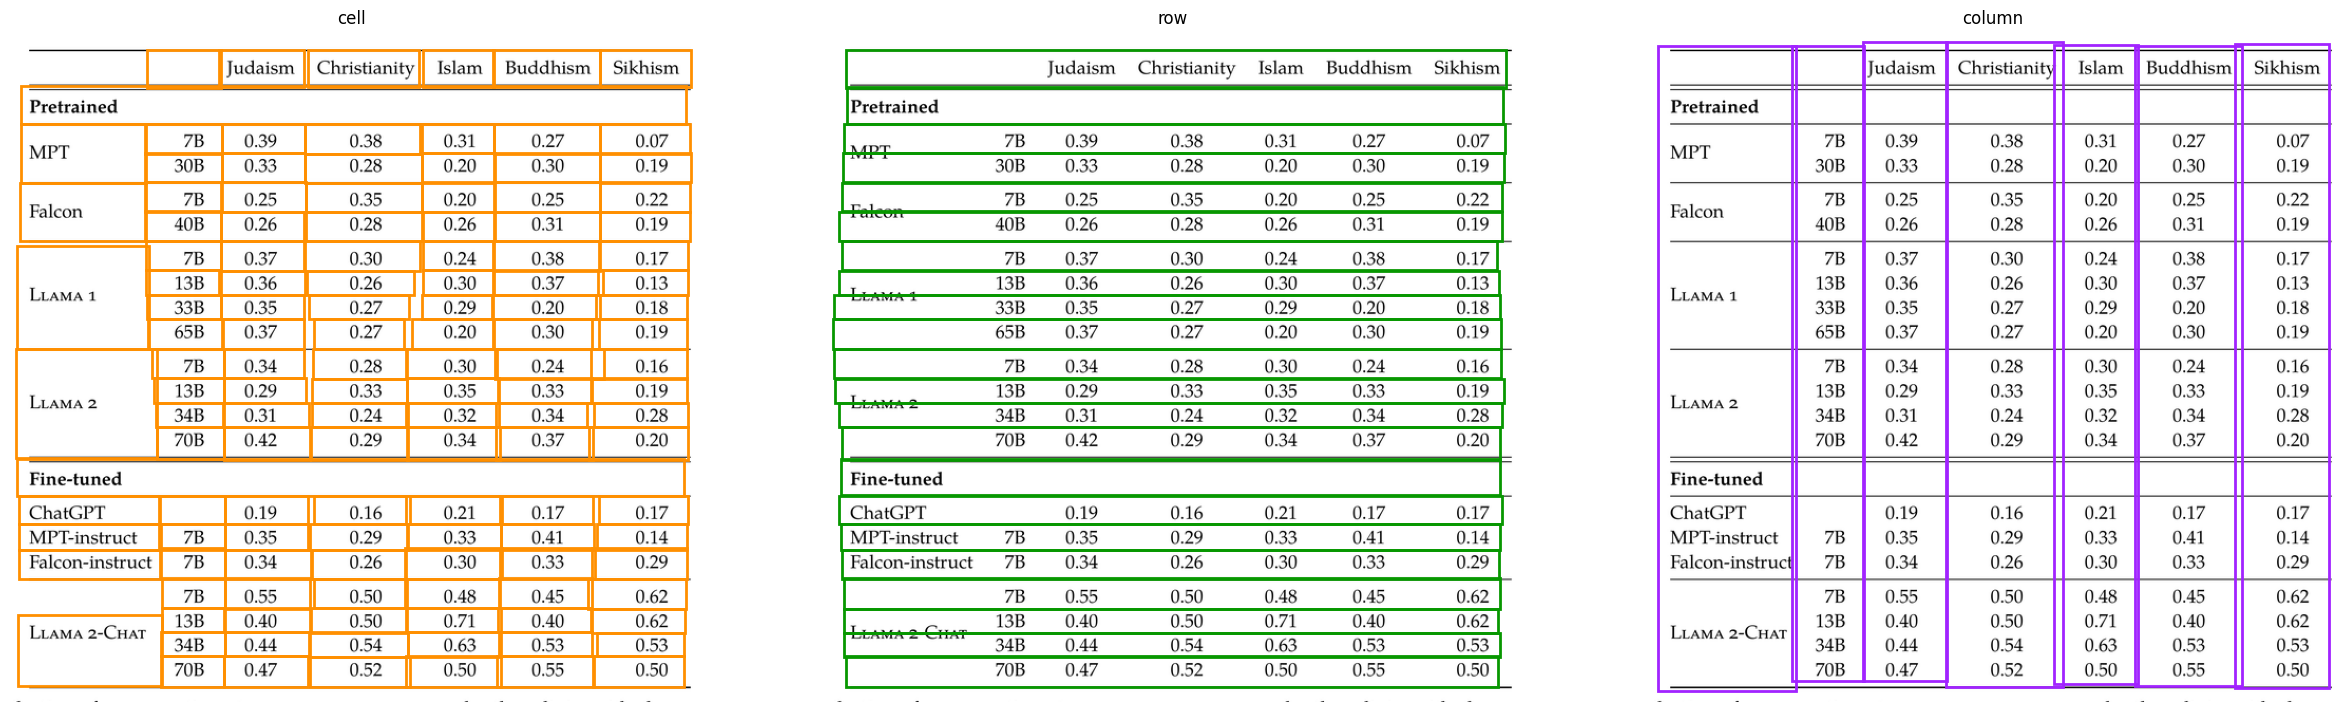

In [16]:
# Plot
boxes_plot, confs = reformat_for_plotting(boxes, labels, scores, img.shape, model.num_classes)

plt.figure(figsize=(30, 15))
for i in range(1, 4):
    boxes_plot_c = [b if j == i else [] for j, b in enumerate(boxes_plot)]
    confs_c = [c if j == i else [] for j, c in enumerate(confs)]

    plt.subplot(1, 3, i)
    plt.title(model.labels[i])
    plot_sample(img, boxes_plot_c, confs_c, labels=model.labels, show_text=False)
plt.show()

### Retrieve table structure
- We show how using the output of [Nemotron OCR](https://huggingface.co/nvidia/nemotron-ocr-v1) you can reconstruct the table.
- The OCR output is precomputed for simplicity
- Note that the code assumes ordering of the row and columns cells !

In [17]:
import pandas as pd

from post_processing.table_struct_pp import (
    assign_boxes,
    merge_text_in_cell,
    build_markdown,
    display_markdown
)

#### OCR results

In [18]:
ocr_preds = pd.read_json('example-ocr.json')
ocr_boxes = ocr_preds[['left', 'lower', 'right', 'upper']].values
ocr_txts = ocr_preds["text"].values

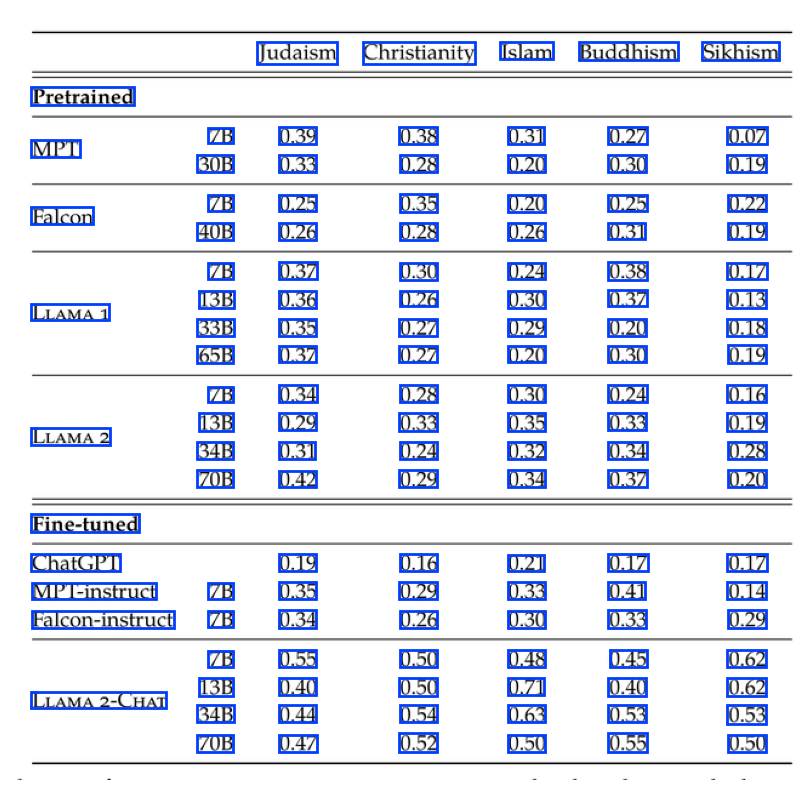

In [19]:
# Plot
boxes_plot, confs = reformat_for_plotting(ocr_boxes, np.zeros(len(ocr_boxes)), np.ones(len(ocr_boxes)), img.shape, 1)

plt.figure(figsize=(15, 10))
plot_sample(img, boxes_plot, confs, labels=model.labels, show_text=False)
plt.show()

#### Un-normalize boxes

In [20]:
boxes_ = boxes.copy()
boxes_[:, [0, 2]] *= img.shape[1]
boxes_[:, [1, 3]] *= img.shape[0]

table_structure_preds = {
    model.labels[c]: boxes_[labels == c] for c in range(model.num_classes)
}

In [21]:
ocr_boxes[:, [0, 2]] *= img.shape[1]
ocr_boxes[:, [1, 3]] *= img.shape[0]

#### Assignment
- For each text, we find the cell with the highest overlap. If none is found, we use the ocr box.
- We then find the corresponding overlapping row and columns.
- If no row/column is found, the text is assumed outside the table.

In [22]:
assignments = []
for i, (b, t) in enumerate(zip(ocr_boxes, ocr_txts)):
    # Find a cell
    matches_cell = assign_boxes(
        b,
        table_structure_preds["cell"].copy(),
        delta=1,
        min_overlap=0.25,
        mode="cell",
    )
    cell = table_structure_preds["cell"][matches_cell[0]] if len(matches_cell) else b

    assert len(matches_cell) == 1

    # Find a row - or more
    matches_row = assign_boxes(
        cell,
        table_structure_preds["row"].copy(),
        delta=2,
        min_overlap=0.1,
        mode="row",
    )
    row_ids = matches_row if len(matches_row) else -1

    # Find a column - or more
    matches_col = assign_boxes(
        cell,
        table_structure_preds["column"].copy(),
        delta=2,
        min_overlap=0.1,
         mode="column",
    )
    col_ids = matches_col if len(matches_col) else -1

    assignments.append(
        {
            "paddle_box": b,
            "is_table": isinstance(col_ids, np.ndarray) and isinstance(row_ids, np.ndarray),
            "cell_id": matches_cell[0] if len(matches_cell) else -1,
            "cell": cell,
            "col_ids": col_ids,
            "row_ids": row_ids,
            "text": t,
        }
    )

    # if i > 10:
    #     break

df_assign = pd.DataFrame(assignments)

In [23]:
df_assign.head(5)

paddle_box  is_table  cell_id  \
0  [203.291015625, 26.54876708984375, 269.2617187...      True        1   
1  [291.251953125, 26.606903076171875, 383.484375...      True        2   
2  [404.05078125, 26.800689697265625, 447.7148437...      True        3   
3  [469.23046875, 26.54876708984375, 550.546875, ...      True        4   
4  [570.796875, 26.7425537109375, 634.07812500000...      True        5   

                                          cell col_ids row_ids          text  
0  [198.55977, 17.590685, 278.7878, 52.456936]     [2]     [0]       Judaism  
1  [282.44125, 17.752846, 387.72543, 52.93876]     [3]     [0]  Christianity  
2  [391.23996, 17.620687, 458.05676, 52.73607]     [4]     [0]         Islam  
3  [457.55814, 17.407358, 559.2739, 52.700333]     [5]     [0]      Buddhism  
4   [559.8162, 17.585682, 645.32104, 52.70492]     [6]     [0]       Sikhism

#### Merge cells with several assigned texts
- This can happen when the OCR splits texts

In [24]:
dfs = []
for cell_id, df_cell in df_assign.groupby("cell_id"):
    if len(df_cell) > 1 and cell_id > -1:
        df_cell = merge_text_in_cell(df_cell)
    dfs.append(df_cell)
df_assign = pd.concat(dfs)

#### Table to text
- We use the assignment to build the table matrix
- Displaying is done in markdown

In [25]:
df_text = df_assign[~df_assign["is_table"]].reset_index(drop=True)
df_table = df_assign[df_assign["is_table"]].reset_index(drop=True)

In [26]:
if len(df_table):
    mat = build_markdown(df_table)
    markdown_table = display_markdown(
        mat, show=True, use_header=False
    )

|  |  | Judaism | Christianity | Islam | Buddhism | Sikhism |
| --- | --- | --- | --- | --- | --- | --- |
| Pretrained | Pretrained | Pretrained | Pretrained | Pretrained | Pretrained | Pretrained |
| MPT | 7B | 0.39 | 0.38 | 0.31 | 0.27 | 0.07 |
| MPT | 30B | 0.33 | 0.28 | 0.20 | 0.30 | 0.19 |
| Falcon | 7B | 0.25 | 0.35 | 0.20 | 0.25 | 0.22 |
| Falcon | 40B | 0.26 | 0.28 | 0.26 | 0.31 | 0.19 |
| LLAMA 1 | 7B | 0.37 | 0.30 | 0.24 | 0.38 | 0.17 |
| LLAMA 1 | 13B | 0.36 | 0.26 | 0.30 | 0.37 | 0.13 |
| LLAMA 1 | 33B | 0.35 | 0.27 | 0.29 | 0.20 | 0.18 |
| LLAMA 1 | 65B | 0.37 | 0.27 | 0.20 | 0.30 | 0.19 |
| LLAMA 2 | 7B | 0.34 | 0.28 | 0.30 | 0.24 | 0.16 |
| LLAMA 2 | 13B | 0.29 | 0.33 | 0.35 | 0.33 | 0.19 |
| LLAMA 2 | 34B | 0.31 | 0.24 | 0.32 | 0.34 | 0.28 |
| LLAMA 2 | 70B | 0.42 | 0.29 | 0.34 | 0.37 | 0.20 |
| Fine-tuned | Fine-tuned | Fine-tuned | Fine-tuned | Fine-tuned | Fine-tuned | Fine-tuned |
| ChatGPT |  | 0.19 | 0.16 | 0.21 | 0.17 | 0.17 |
| MPT-instruct | 7B | 0.35 | 0.29 | 0.33 | 0.41 | 0.14 |
| Falcon-instruct | 7B | 0.34 | 0.26 | 0.30 | 0.33 | 0.29 |
|  | 7B | 0.55 | 0.50 | 0.48 | 0.45 | 0.62 |
| LLAMA 2-CHAT | 13B | 0.40 | 0.50 | 0.71 | 0.40 | 0.62 |
| LLAMA 2-CHAT | 34B | 0.44 | 0.54 | 0.63 | 0.53 | 0.53 |
| LLAMA 2-CHAT | 70B | 0.47 | 0.52 | 0.50 | 0.55 | 0.50 |

Done !